# Named Entity Recognition (NER)

## Purpose of the Project
* We will be doing Named Entity Recognition (NER) with XLM-RoBERTa model in this project.
* NER is harder than text classification.
* NER is a token classification task. In this analysis, each token will be classified. (a noun as "person", a company as "organization", or a place name as "place")

## Road Map of the Project
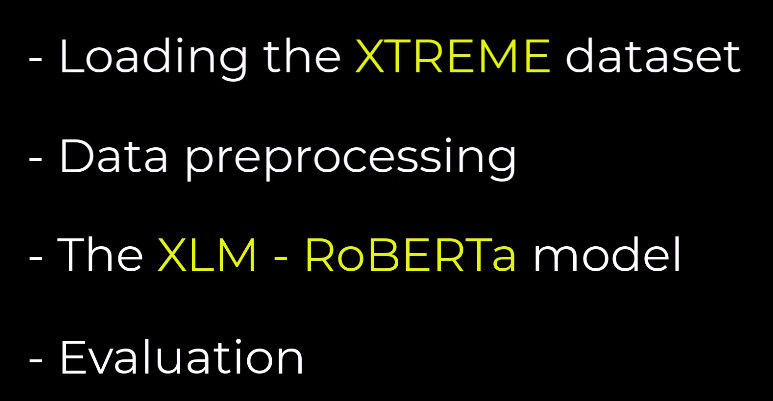

## About the Model
* Models written for one language do not work well when text in another language is entered.
* Multilingual transformers can be used for this.
* These models, like BERT, use masked language modeling.
* Some random words in the text are masked and these masked words are asked to be guessed.
* Multilingual transformers models are trained with this technique.
* These models are trained independently of the language. That's why it can be adapted to many languages.
* XLM-R model was trained on 100 languages.
* This model is an extension and optimization of BERT.

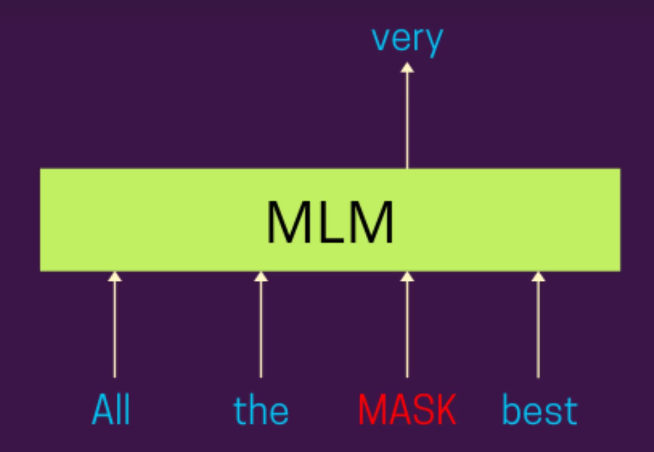

## Loading the Dataset for NER
* The 4 most used languages in Switzerland from the XTREME dataset will be used. (German, French, Italian, English)

In [1]:
!pip install -q datasets

In [2]:
from datasets import load_dataset

In [3]:
langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059] #frequency assignment according to the rate at which languages are spoken

In [4]:
from collections import defaultdict
# This library assigns a default value for a key not found in the dictionary.

In [5]:
from datasets import DatasetDict

panx_ch = defaultdict (DatasetDict)

In [6]:
# creating datasets
for lang, frac in zip(langs, fracs):
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    for split in ds:
        panx_ch[lang][split] = (
            ds[split].shuffle(seed=0).select(range(int(frac*ds[split].num_rows))))

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
# understanding dataset
import pandas as pd

In [8]:
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
            index = ["number of training examples"])

,de,fr,it,en
number of training examples,12580,4580,1680,1180


* We will train the model with German, then we'll use that model for other languages.

In [9]:
#first example of german
element = panx_ch["de"]["train"][0]

for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


* There are 3 columns. **Tokens**, **ner_tags** and **langs**.
* **ner_tags** column has numerical representation of tags such as place, person, organisation...

In [10]:
# see tags of numerical representations
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [11]:
# taking a closer look at the ner_tags column
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [12]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

In [13]:
# applying the function to the dataset with map() method
panx_de = panx_ch["de"].map(create_tag_names)

  0%|          | 0/12580 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

In [14]:
de_example = panx_de["train"][0]

pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
            ["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [15]:
# distribution of tags in the dataset
from collections import Counter

In [16]:
split2freqs = defaultdict(Counter)

In [17]:
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] +=1

In [18]:
pd.DataFrame.from_dict(split2freqs, orient = "index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


## Data Preprocessing

### 1- BERT Tokenizer vs. XLM-R Tokenizer
* BERT uses **WordPiece tokenizer** technique which uses **subword technique**.
* XLM-R uses **SentencePiece tokenizer**.
* SentencePiece technique does language-independent tokenization.

In [19]:
from transformers import AutoTokenizer

In [20]:
# importing both tokenizers 
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
xlmr_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [21]:
# with the help of the sample text, let's explore how tokenizers divide text
text = "Tim Sparrow lives in San Diego!"

In [22]:
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [23]:
pd.DataFrame([bert_tokens, xlmr_tokens], index = ["BERT", "XLM-R"])

,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Tim,Spa,##rrow,lives,in,San,Diego,!,[SEP]
XLM-R,<s>,▁Tim,▁Spar,row,▁lives,▁in,▁San,▁Diego,!,</s>


* If a word doesn't have underscore as a prefix, it means that word has a connection with previous word.

* (BERT model)
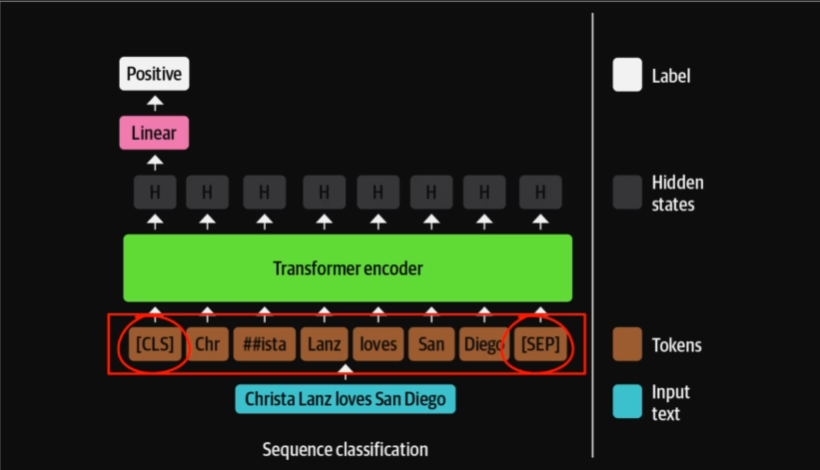

* NER Analysis
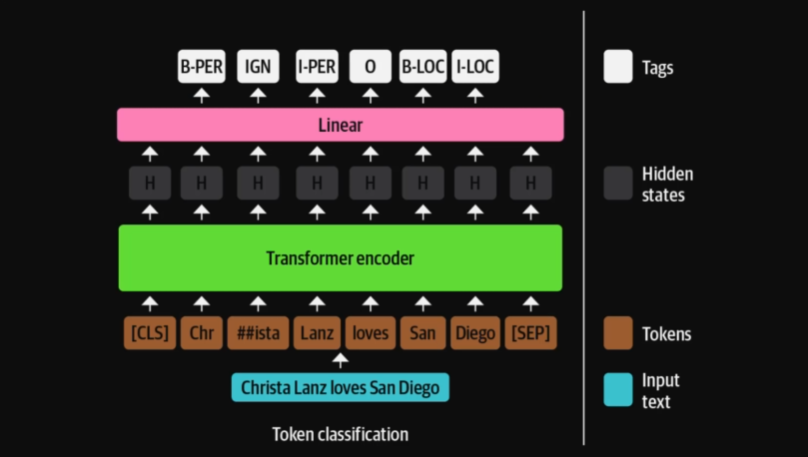

### 2- Loading the Model

In [24]:
from transformers import XLMRobertaForTokenClassification

In [25]:
xlmr_model_name = "xlm-roberta-base"

In [26]:
# creating variables to convert index to label and label to index
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
num_labels = tags.num_classes

In [27]:
index2tag

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC'}

In [28]:
num_labels

7

In [29]:
# for training the model on gpu
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

xlmr_model = XLMRobertaForTokenClassification.from_pretrained(
    xlmr_model_name,
    num_labels = num_labels,
    id2label = index2tag,
    label2id = tag2index).to(device)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


* Now, the model is ready to be trained.
* Let's see if the tokenizer and model are working correctly.

In [30]:
text

'Tim Sparrow lives in San Diego!'

In [31]:
input_ids = xlmr_tokenizer.encode(text, return_tensors = "pt") # "pt" for pytorch

In [32]:
pd.DataFrame(
    [xlmr_tokens, input_ids[0].numpy()],
    index = ["Tokens", "Input IDs"]
)

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Tim,▁Spar,row,▁lives,▁in,▁San,▁Diego,!,</s>
Input IDs,0,13320,37456,15555,60742,23,1735,59826,38,2


In [33]:
outputs = xlmr_model(input_ids.to(device)).logits

* Now, prediction was made for each token.

In [34]:
outputs.shape

torch.Size([1, 10, 7])

* First dimension shows batch size, second dimension shows the length of the text and the last dimension shows number of tags.

In [35]:
# predicting the labels of each token
predictions = torch.argmax(outputs, dim=-1)

In [36]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]

### 3- Setting Tokenizer and Metrics

In [37]:
# displaying tokens and their predicted tags
pd.DataFrame( [xlmr_tokens, preds], index = ["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Tim,▁Spar,row,▁lives,▁in,▁San,▁Diego,!,</s>
Tags,B-LOC,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER


In [38]:
def tag_text(text, tags, model, tokenizer):
    tokens = tokenizer(text).tokens()
    input_ids = xlmr_tokenizer.encode(
        text, return_tensors = "pt").to(device)
    outputs = model(input_ids)[0]
    predictions = torch.argmax(outputs, dim=2)
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index = ["Tokens", "Tags"])

In [39]:
# Assigning the words in the german dataset and the labels of these words to a variable
words, labels = de_example["tokens"], de_example["ner_tags"]

In [40]:
#visualize previous cell
pd.DataFrame([words, labels], index = ["words", "labels"])

,0,1,2,3,4,5,6,7,8,9,10,11
words,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
labels,0,0,0,0,5,6,0,0,5,5,6,0


In [43]:
# we gave the tokens to xlmr tokenizer
tokenized_input = xlmr_tokenizer(de_example["tokens"],
                                 is_split_into_words = True)

In [44]:
# converting numerical representations into tokens
tokens = xlmr_tokenizer.convert_ids_to_tokens(
    tokenized_input["input_ids"]
)

In [45]:
#visualize previous cell
pd.DataFrame([tokens], index = ["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


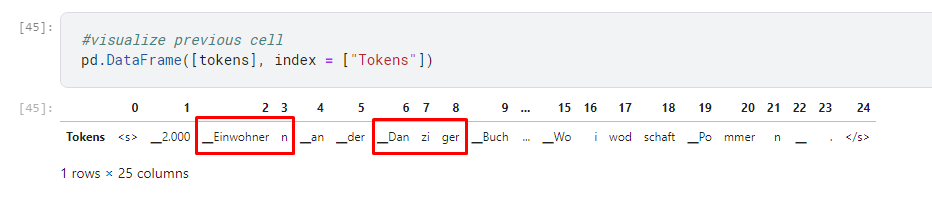
* The words marked with a red rectangle are normally combined, but the tokenizer has separated them. We will use the ***word_ids*** function to assign the label of the other token to these reserved sections.

In [46]:
word_ids = tokenized_input.word_ids()

In [47]:
pd.DataFrame([tokens, word_ids], index = ["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


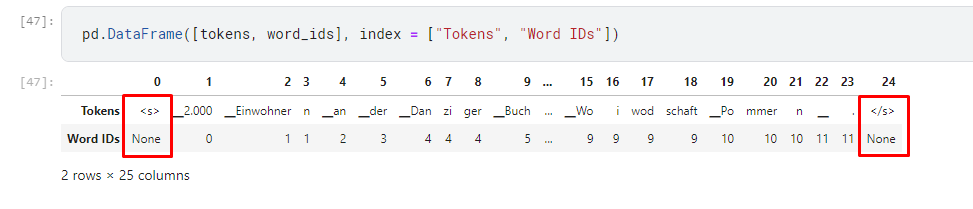
* Special tokens such as **"s"** are assigned a value of  "None". To eliminate this, we will assign a value of "-100" to these special tokens.
* This is because the **"CrossEntropyLoss"** class in the pytorch library ignores the value -100.

In [48]:
previous_word_idx = None
label_ids = []
for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]

index = ["Tokens", "Word IDs", "Label IDs", "Labels"]
pd.DataFrame([tokens, word_ids, label_ids, labels], index = index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [49]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], 
                                     truncation = True,
                                     is_split_into_words = True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs      

In [50]:
# apply to the whole dataset with map() method
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels,
                     batched=True,
                     remove_columns=["langs", "ner_tags", "tokens"])

In [51]:
# apply the function to german dataset
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

* Now, our dataset is ready to train for NER Analysis.
* Before fine-tuning, let's set metrics to evaluate the model.
* For this, we can use ***seqeval*** library.

In [52]:
y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]

In [53]:
!pip install seqeval

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=388f68b0abb9b465e2c9809f48ff91dd13bc85c2b6d9bab48a2a7d0999bcced5
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [54]:
from seqeval.metrics import classification_report

In [55]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [56]:
import numpy as np

In [57]:
def align_prediction(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[bathc_idx][seq_idx]])
                example_preds.append(index2tag[preds[bathc_idx][seq_idx]])
        
        labels_list.append(example_labels)  
        preds_list.append(example_preds) 
    
    return preds_list, labels_list

* This function will take outputs from the model and convert to format for seqeval library.